# Prepare

In [1]:
import os, yaml, random, uproot, json, correctionlib
import numpy as np
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, BaseSchema
import scipy as sp
import scipy.stats as sps
from scipy.interpolate import CubicSpline

import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import pandas as pd

if 'fit' not in os.getcwd():
    os.chdir('fit')

In [2]:
content = []
for mass in os.listdir('datacard/Run2'):
    for SR in ['SRH_N', 'SRZ_N', 'SRZ_W', 'SRZ_VW']:
        datacard = os.path.join('datacard/Run2', mass, f'{SR}.txt') 
        name = f'.{mass}.{SR}'
        content.append(f'{datacard}\t{name}')
with open('/afs/cern.ch/user/d/dfu/datacards/Arguments.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(content))

FileNotFoundError: [Errno 2] No such file or directory: '/afs/cern.ch/user/d/dfu/datacards/Arguments.txt'

In [ ]:
tagger_cut = {
    'down': {'SRZ1': 0.8, 'SRZ2': 0.98},
    'up': {'SRZ1': 0.98, 'SRZ2': 2}
}

In [44]:
from matplotlib.cm import get_cmap
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)

hep.style.use("CMS")


use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)


def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return np.abs(h), var

def error_bar(h, var, mode='data'):
    from scipy.interpolate import CubicSpline
    
    h, var = np.array(h), np.array(var)
    if mode == 'data':
        number = h
    elif mode == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = np.nan_to_num(h**2/var, nan=0)
    else:
        raise ValueError("mode should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>=0) & (number<=10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    
    if mode == 'mc':
        up_error_bar *= np.nan_to_num(var/h, nan=1)
        down_error_bar *= np.nan_to_num(var/h, nan=1)

    return np.array([down_error_bar, up_error_bar])

/tmp/dfu/ipykernel_3004134/2958293359.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)


# PES/JES variated templates

In [ ]:
from matplotlib.cm import get_cmap
from cycler import cycler

hep.style.use("CMS")
mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)

def variated_signal_template(parameters, plot_name: str, x_name: str, year='Run2', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, function=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI['Run2'] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = (x_max - x_min)//bin_width

    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.1)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=round(LUMI[year],1), fontsize=18, llabel='Preliminary')


    ## analyze    
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    x_data = x_axis.centers
    fit = {}


    ## plot
    fit['nominal'] = function(x_data, **parameters['nominal'])
    fit['nominal'] = fit['nominal']/np.max(fit['nominal'])
    for (k, param) in parameters.items():
        fit[k] = function(x_data, **param)
        fit[k] = fit[k] / np.max(fit[k])
        ax.plot(x_data, fit[k], label=k, linestyle='--', linewidth=2)
        ax1.plot(x_data, fit[k]/fit['nominal'], linestyle='--', linewidth=2)


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1.2*ax.get_ylim()[1])
    ax.set_xticklabels([])

    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_ylabel(f'A.U.', fontsize=20, ha='right', y=1)

    # ratio panel
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0, 2)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_ylabel('ratio', fontsize=20, ha='center', y=0.5)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)


    ## title, text and legend
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    if not os.path.exists(f'../plots/fit/{year}'):
        os.makedirs(f'../plots/fit/{year}')
    plt.savefig(f"../plots/fit/{year}/{plot_name}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
y = 'Run2'
k = r'700$\to H(bb)\gamma$'
mass = int(k.split('$')[0])

for unc in ['PES', 'JES']:
    for SR in ['SR1', 'SR2']:
        SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

        
        with open(f'workspace/{y}/{mass}/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        with open(f'../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
            systematics = yaml.safe_load(f)
        if unc == 'PES':
            systematics[unc][SR][mass] = 2*systematics[unc][SR][mass] - 1
        elif unc == 'JES':
            systematics[unc][SR][mass] = 0.5*systematics[unc][SR][mass]+0.5
        parameters = {'nominal': {}, unc+r'$:+1\sigma$': {}, unc+r'$:-1\sigma$': {}}
        for i in parameters:
            for p in ['x0', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'nR']:
                if p.startswith('x0') and '+' in i:
                    parameters[i][p] = fit_info[p] * (systematics[unc][SR][mass])
                elif p.startswith('x0') and '-' in i:
                    parameters[i][p] = fit_info[p] * (2-systematics[unc][SR][mass])
                else:
                    parameters[i][p] = fit_info[p]
        variated_signal_template(parameters, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'{unc}_variation_Hbb_{mass}_{SR}', bin_width=5, x_min=550, x_max=850, year=y, function=crystal_ball)

In [ ]:
y = 'Run2'
k = r'1000$\to H(bb)\gamma$'
mass = int(k.split('$')[0])

for unc in ['PES', 'JES']:
    for SR in ['SR1', 'SR2']:
        SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

        
        with open(f'workspace/{y}/{mass}/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        with open(f'../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
            systematics = yaml.safe_load(f)
        if unc == 'PES':
            systematics[unc][SR][mass] = 2*systematics[unc][SR][mass] - 1
        elif unc == 'JES':
            systematics[unc][SR][mass] = systematics[unc][SR][mass]

        parameters = {'nominal': {}, unc+r'$:+1\sigma$': {}, unc+r'$:-1\sigma$': {}}
        for i in parameters:
            for p in ['x0', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'nR']:
                if p.startswith('x0') and '+' in i:
                    parameters[i][p] = fit_info[p] * (systematics[unc][SR][mass])
                elif p.startswith('x0') and '-' in i:
                    parameters[i][p] = fit_info[p] * (2-systematics[unc][SR][mass])
                else:
                    parameters[i][p] = fit_info[p]
        variated_signal_template(parameters, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'{unc}_variation_Hbb_{mass}_{SR}', bin_width=5, x_min=700, x_max=1200, year=y, function=crystal_ball)

In [ ]:
y = 'Run2'
k = r'2000$\to H(bb)\gamma$'
mass = int(k.split('$')[0])

for unc in ['PES', 'JES']:
    for SR in ['SR1', 'SR2']:
        SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

        
        with open(f'workspace/{y}/{mass}/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        with open(f'../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
            systematics = yaml.safe_load(f)
        

        parameters = {'nominal': {}, unc+r'$:+1\sigma$': {}, unc+r'$:-1\sigma$': {}}
        for i in parameters:
            for p in ['x0', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'nR']:
                if p.startswith('x0') and '+' in i:
                    parameters[i][p] = fit_info[p] * (systematics[unc][SR][mass])
                elif p.startswith('x0') and '-' in i:
                    parameters[i][p] = fit_info[p] * (2-systematics[unc][SR][mass])
                else:
                    parameters[i][p] = fit_info[p]
        variated_signal_template(parameters, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'{unc}_variation_Hbb_{mass}_{SR}', bin_width=5, x_min=1600, x_max=2300, year=y, function=crystal_ball)

In [ ]:
y = 'Run2'
k = r'3000$\to H(bb)\gamma$'
mass = int(k.split('$')[0])

for unc in ['PES', 'JES']:
    for SR in ['SR1', 'SR2']:
        SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

        
        with open(f'workspace/{y}/{mass}/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        with open(f'../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
            systematics = yaml.safe_load(f)
        

        parameters = {'nominal': {}, unc+r'$:+1\sigma$': {}, unc+r'$:-1\sigma$': {}}
        for i in parameters:
            for p in ['x0', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'nR']:
                if p.startswith('x0') and '+' in i:
                    parameters[i][p] = fit_info[p] * (systematics[unc][SR][mass])
                elif p.startswith('x0') and '-' in i:
                    parameters[i][p] = fit_info[p] * (2-systematics[unc][SR][mass])
                else:
                    parameters[i][p] = fit_info[p]
        variated_signal_template(parameters, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'{unc}_variation_Hbb_{mass}_{SR}', bin_width=5, x_min=2500, x_max=3300, year=y, function=crystal_ball)

In [ ]:
y = 'Run2'
k = r'3500$\to H(bb)\gamma$'
mass = int(k.split('$')[0])

for unc in ['PES', 'JES']:
    for SR in ['SR1', 'SR2']:
        SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

        
        with open(f'workspace/{y}/{mass}/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        with open(f'../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
            systematics = yaml.safe_load(f)
        

        parameters = {'nominal': {}, unc+r'$:+1\sigma$': {}, unc+r'$:-1\sigma$': {}}
        for i in parameters:
            for p in ['x0', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'nR']:
                if p.startswith('x0') and '+' in i:
                    parameters[i][p] = fit_info[p] * (systematics[unc][SR][mass])
                elif p.startswith('x0') and '-' in i:
                    parameters[i][p] = fit_info[p] * (2-systematics[unc][SR][mass])
                else:
                    parameters[i][p] = fit_info[p]
        variated_signal_template(parameters, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'{unc}_variation_Hbb_{mass}_{SR}', bin_width=5, x_min=2500, x_max=3300, year=y, function=crystal_ball)

# Signal injection

In [ ]:
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]
for m in MASS:
    datacard = os.path.join('~/NanoAnalysis/fit/datacard/Run2', str(m), 'SRH.txt')
    for mu in [0.1]:
        os.system(f'combine -M MultiDimFit {datacard} -t -1 --expectSignal={mu} -n -{m}-{mu}- --algo singles --rMin -1')

 <<< Combine >>> 
 <<< v10.0.2 >>>
>>> Random number generator seed is 123456
>>> Method used is MultiDimFit
Doing initial fit: 

 --- MultiDimFit ---
best fit parameter values and profile-likelihood uncertainties: 
   r :    +0.113   -0.074/+0.078 (68%)
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
 <<< v10.0.2 >>>
>>> Random number generator seed is 123456
>>> Method used is MultiDimFit
Doing initial fit: 

 --- MultiDimFit ---
best fit parameter values and profile-likelihood uncertainties: 
   r :    +0.101   -0.042/+0.047 (68%)
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
 <<< v10.0.2 >>>
>>> Random number generator seed is 123456
>>> Method used is MultiDimFit
Doing initial fit: 

 --- MultiDimFit ---
best fit parameter values and profile-likelihood uncertainties: 
   r :    +0.100   -0.033/+0.037 (68%)
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
 <<< v10.0.2 >>>
>>> Random number generator seed is 123456
>>> Method used is MultiDimFit
Doing 

Error in <ROOT::Math::Fitter::CalculateMinosErrors>: Minos error calculation failed for all the selected parameters


   r :    +0.100   -1.100/+0.115 (68%)
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
 <<< v10.0.2 >>>
>>> Random number generator seed is 123456
>>> Method used is MultiDimFit
Doing initial fit: 
FASTEXIT from pdf_binSRH2_obsOnly
RooAbsMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (5.09723e-05) to force MIGRAD to back out of this region. Error log follows.
Parameter values: 	Br_Hbb=0.00661798	CSEV=0.00052769	JER=-0.00213697	JES_2016=0.00235334	JES_2017=0.00078329	JES_2018=6.63532e-17	L1_prefiring=0.00211337	PDF=0.0249938	PER=-0.000808018	PES=0.00183057	QCD_scale=0.00631721	Xbb_tagger_SR1=0.00301826	Xbb_tagger_SR2=0.024495	lumi_13TeV_1718=0.00144289	lumi_13TeV_2016=0.00130407	lumi_13TeV_2017=0.00322296	lumi_13TeV_2018=0.00349834	lumi_13TeV_correlated=0.00690392	photon_ID=0.0228021	pile-up=0.00526692	r=-0.0890818	shapeBkg_background_SRH1__norm=466.202	shapeBkg_background_SRH2__norm=23.0587
RooAbsReal::SRH2[ params=(Br_Hbb,CSEV,JER,JES_2016,L1

Error in <ROOT::Math::Fitter::CalculateMinosErrors>: Minos error calculation failed for all the selected parameters


In [ ]:
signal_strength = {'0': {}, '0.1': {}, '1': {}}
signal_strength_err = {'0': {}, '0.1': {}, '1': {}}
for f in os.listdir('.'):
    if not f.endswith('.root') or '123456' in f or 'MultiDimFit' not in f:
        continue
    mass = int(f.split('-')[1])
    r_gen = f.split('-')[2]
    a = uproot.open(f)
    r = a['limit']['r'].array()
    signal_strength[r_gen][mass] = r[0]#np.mean(r)
    signal_strength_err[r_gen][mass] = [r[0]-r[1], r[2]-r[1]]#np.std(r)

In [ ]:
hep.style.use("CMS")

def plot_pull(r, r_err, r_gen, plot_name: str, x_name=r'$m_{Z^\prime}$ (GeV)', x_min=500, x_max=4000,):

    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.08)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=False, ax=ax, fontsize=18, llabel='Simulation', lumi=137.6)
        
    ## plot
    mass = list(r.keys())
    signal_strength = np.array(list(r.values()))
    #signal_strength_err = np.array(list(r_err.values()))
    signal_strength_err = np.array([r_err[:,0], r_err[:,1]])
    ax.errorbar(x=mass, y=signal_strength, yerr=signal_strength_err, linestyle='')
    ax.scatter(x=mass, y=signal_strength, label=r'Fit on Asimov toy with $r_{truth}=$'+f'{r_gen} injection', s=50)
    ax.plot([x_min,x_max], [r_gen, r_gen], color='gray', linestyle='dashed')
    ax1.plot([x_min,x_max], [0, 0], color='black', linestyle='solid')
    ax1.plot([x_min,x_max], [0.5, 0.5], color='gray', linestyle='dashed')
    ax1.plot([x_min,x_max], [-0.5, -0.5], color='gray', linestyle='dashed')
    ax1.fill_between([x_min,x_max], [0.5, 0.5], [-0.5, -0.5], color='Gainsboro')
    ax1.scatter(x=mass, y=(signal_strength-r_gen)/np.mean(signal_strength_err, axis=0), s=50, label='Pull')
    
    ## axises
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(1.2*ax.get_ylim()[0]-0.2*r_gen, 1.2*ax.get_ylim()[1]-0.2*r_gen)
    ax.set_ylabel(r'$\hat{r}_{fit}$', ha='right', fontsize=24, y=1)

    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(-1, 1)
    ax1.set_ylabel(r'$(\hat{r}_{fit}-r_{truth})/\sigma_{fit}$', ha='right', fontsize=20, y=1)

    ## title, text and legend
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    ax1.legend(loc="best", ncol=1, frameon=False, fontsize=18)

    ## finalizing
    if not os.path.exists('../plots'):
        os.makedirs('../plots')
    plt.savefig(f"../plots/{plot_name}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
np.array(signal_strength_err['1'].values())

array(dict_values([[0.1276055, 0.26552564], [0.10138619, 0.2138269], [0.09255898, 0.1938554], [0.08951056, 0.18713534], [0.09183425, 0.19176787], [0.09842652, 0.20521289], [0.10857016, 0.22779292], [0.122085154, 0.25696295], [0.13777453, 0.29169005], [0.15827566, 0.33729535], [0.18224561, 0.3912784], [0.21184486, 0.45964283], [0.29045647, 0.64975077], [0.4413218, 1.0569918]]),
      dtype=object)

TypeError: unhashable type: 'slice'

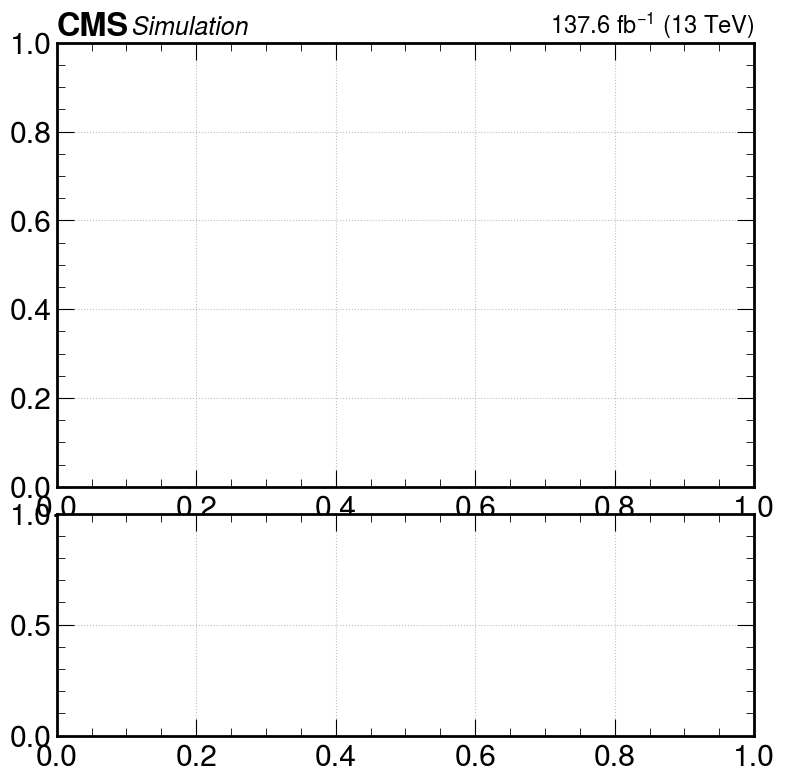

In [ ]:
plot_pull(signal_strength['1'], signal_strength_err['1'], r_gen=1, plot_name='signal_injection_r=1')

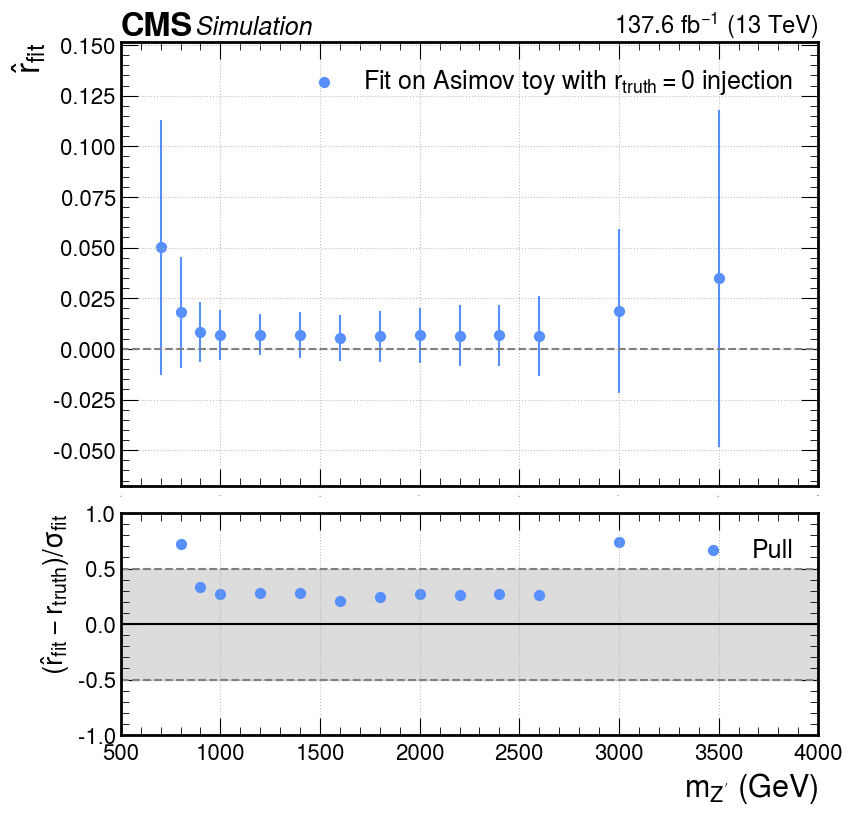

In [ ]:
plot_pull(signal_strength['0'], signal_strength_err['0'], r_gen=0, plot_name='signal_injection_r=0')

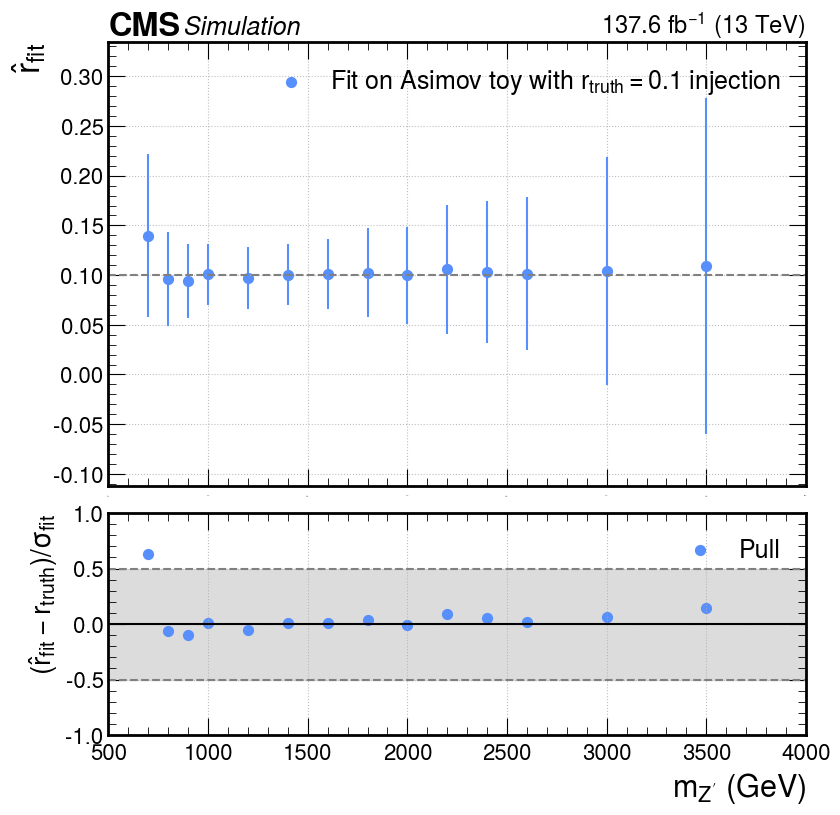

In [ ]:
plot_pull(signal_strength['0.1'], signal_strength_err['0.1'], r_gen=0.1, plot_name='signal_injection_r=0.1')

# Cross-section upper limits

In [2]:
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]


In [3]:
from scipy.interpolate import CubicSpline
hep.style.use("CMS")

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)
plt.rcParams["mathtext.fontset"] = "stix"

def plot_cross_section_limit(limits, llabel, text, cross_section_nominal=None, x_name='Resonance mass (GeV)', y_name=r'$\sigma[Z^\mathrm{\prime}\to H\gamma]$', name: str='combine', year='Run2', x_min=650/1000, x_max=3550/1000, y_min=1e-2, y_max=3e2):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))

    ## canvas initializing
    # colorlist=['red', 'blue', 'green', 'black', 'cyan', 'darkorange', 'darkviolet', 'SlateGray', 'HotPink', 'LightSkyBlue']
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    f = plt.figure(figsize=(9, 9))
    ax = plt.gca()
    #plt.grid()
    hep.cms.label(loc=1, data=True, ax=ax, fontsize=23, llabel='', rlabel=f'{round(LUMI[year])} '+r'$fb^{-1}$'+' (13 TeV)', italic=(False, True, False), fontname='sans-serif')
    hep.cms.text(text=llabel, loc=2, fontsize=23, italic=(False, False, False))
        
    ## plot
    mass = limits['mass']
    x = np.arange(700, 3501, 10)/1000
    #plt.fill_between(x, CubicSpline(mass, limits['Expected +2sigma'])(x), CubicSpline(mass, limits['Expected -2sigma'])(x), color='#85D1FBff', label='95% expected')
    plt.fill_between(x, CubicSpline(mass, limits['Expected +2sigma'])(x), CubicSpline(mass, limits['Expected -2sigma'])(x), color='#F5BB54', label='95% expected')
    #plt.fill_between(x, CubicSpline(mass, limits['Expected +1sigma'])(x), CubicSpline(mass, limits['Expected -1sigma'])(x), color='#FFDF7Fff', label='68% expected')
    plt.fill_between(x, CubicSpline(mass, limits['Expected +1sigma'])(x), CubicSpline(mass, limits['Expected -1sigma'])(x), color='#607641', label='68% expected')
    plt.plot(x, CubicSpline(mass, limits['Expected Limit'])(x), color='black', label='Expected', linestyle='dashed')
    plt.plot(x, CubicSpline(mass, limits['Observed Limit'])(x), color='black', label='Observed', linestyle='solid')
    if cross_section_nominal is not None:
        plt.plot(np.array(MASS)/1000, [cross_section_nominal[m] for m in MASS], label='Theory benchmark', color='red', linestyle='solid')

    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_yscale('log')
    #ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=20)

    ## title, text and legend
    ax.legend(loc=('upper' if '0.0' in text else 'lower') + ' right', ncol=1, frameon=False, fontsize=22)
    ax.text(0.8, 5e1, s=text, fontsize=21, ha='left', va='top')
    ax.set_xlabel(x_name, fontsize=24, ha='right', x=1)
    ax.set_ylabel('95% CL upper limit on '+y_name+' (fb)', fontsize=24, ha='right', y=1)

    ## finalizing
    os.makedirs(f'../postprocess/plots/fit/{year}', exist_ok=True)
    plt.savefig(f"../postprocess/plots/fit/{year}/limits_{name}.pdf", bbox_inches='tight')
    plt.show()

## Hgamma

In [4]:
with open('../src/parameters/cross-section.yaml', 'r') as f:
    xsec = yaml.safe_load(f)

cross_section_nominal = {
    int(k.split('_M')[1]): xsec['ZpToHG'][k]*1e3 for k in xsec['ZpToHG']
}

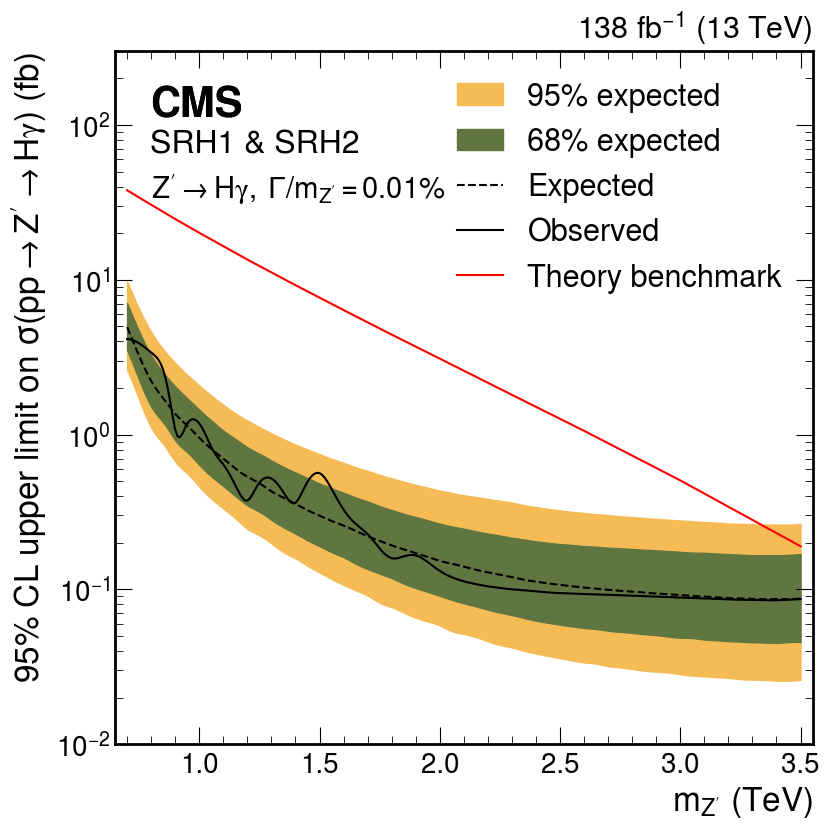

In [5]:
for SR in ['SRH']:
    limits = pd.read_csv(f'./limit_results/limit_{SR}_N.csv')
    result = {
        'mass': limits['mass'].values/1000,
        'Expected +2sigma': limits['limit_p2'].values,
        'Expected +1sigma': limits['limit_p1'].values,
        'Expected -1sigma': limits['limit_m1'].values,
        'Expected -2sigma': limits['limit_m2'].values,
        'Expected Limit': limits['limit_exp'].values,
        'Observed Limit': limits['limit_obs'].values,
    }
    plot_cross_section_limit(limits=result, llabel='SRH1 & SRH2', text=r'$Z^\prime\to H\mathrm{\gamma},\ \Gamma/m_{Z^\prime}=0.01\%$', name=f'{SR}_N', x_name=r'$m_{Z^\prime}$ (TeV)', y_name=r'$\sigma(pp\to Z^\prime\to H\mathrm{\gamma})$', year='Run2', y_min=1e-2, cross_section_nominal=cross_section_nominal)

## Zgamma

### narrow

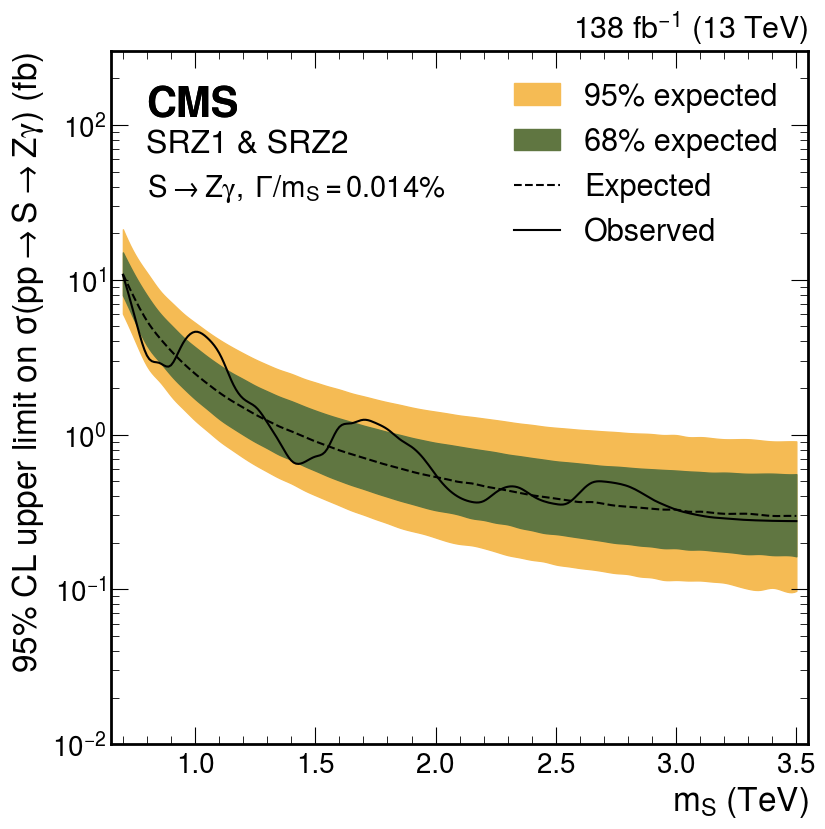

In [6]:
for SR in ['SRZ']:
    limits = pd.read_csv(f'./limit_results/limit_{SR}_N.csv')
    result = {
        'mass': limits['mass'].values/1000,
        'Expected +2sigma': limits['limit_p2'].values,
        'Expected +1sigma': limits['limit_p1'].values,
        'Expected -1sigma': limits['limit_m1'].values,
        'Expected -2sigma': limits['limit_m2'].values,
        'Expected Limit': limits['limit_exp'].values,
        'Observed Limit': limits['limit_obs'].values,
    }
    plot_cross_section_limit(limits=result, llabel='SRZ1 & SRZ2', text=r'$S\to Z\mathrm{\gamma},\ \Gamma/m_S=0.014\%$', name=f'{SR}_N', x_name=r'$m_S$ (TeV)', y_name=r'$\sigma(pp\to S\to Z\mathrm{\gamma})$', year='Run2', y_min=1e-2)

### wide

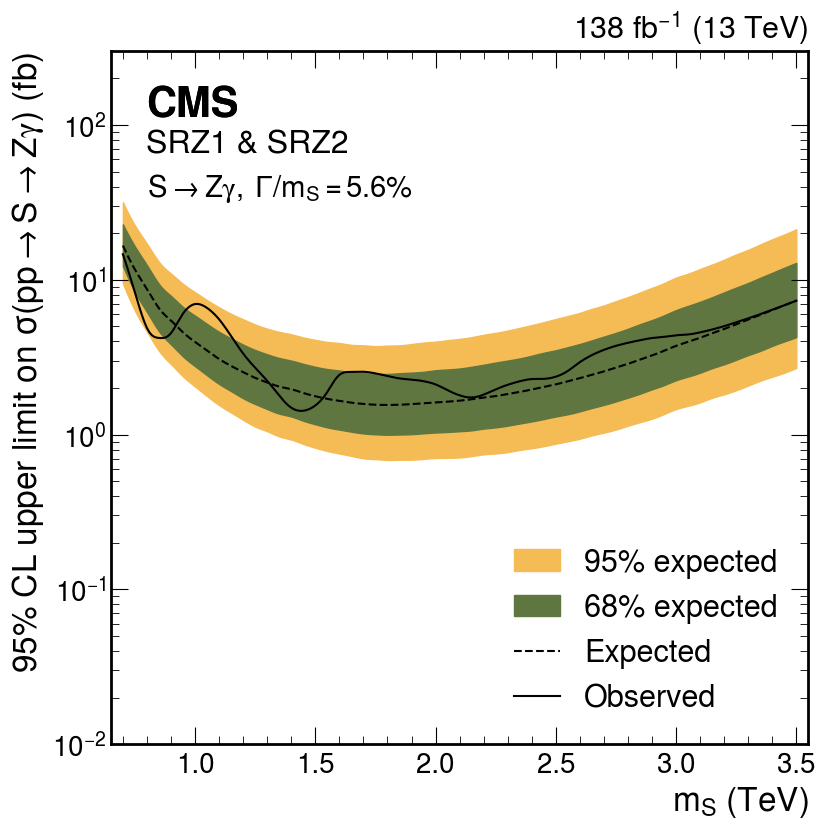

In [7]:
for SR in ['SRZ']:
    limits = pd.read_csv(f'./limit_results/limit_{SR}_W.csv')
    result = {
        'mass': limits['mass'].values/1000,
        'Expected +2sigma': limits['limit_p2'].values,
        'Expected +1sigma': limits['limit_p1'].values,
        'Expected -1sigma': limits['limit_m1'].values,
        'Expected -2sigma': limits['limit_m2'].values,
        'Expected Limit': limits['limit_exp'].values,
        'Observed Limit': limits['limit_obs'].values,
    }
    plot_cross_section_limit(limits=result, llabel='SRZ1 & SRZ2', text=r'$S\to Z\mathrm{\gamma},\ \Gamma/m_S=5.6\%$', name=f'{SR}_W', x_name=r'$m_S$ (TeV)', y_name=r'$\sigma(pp\to S\to Z\mathrm{\gamma})$', year='Run2', y_min=1e-2)

### very wide

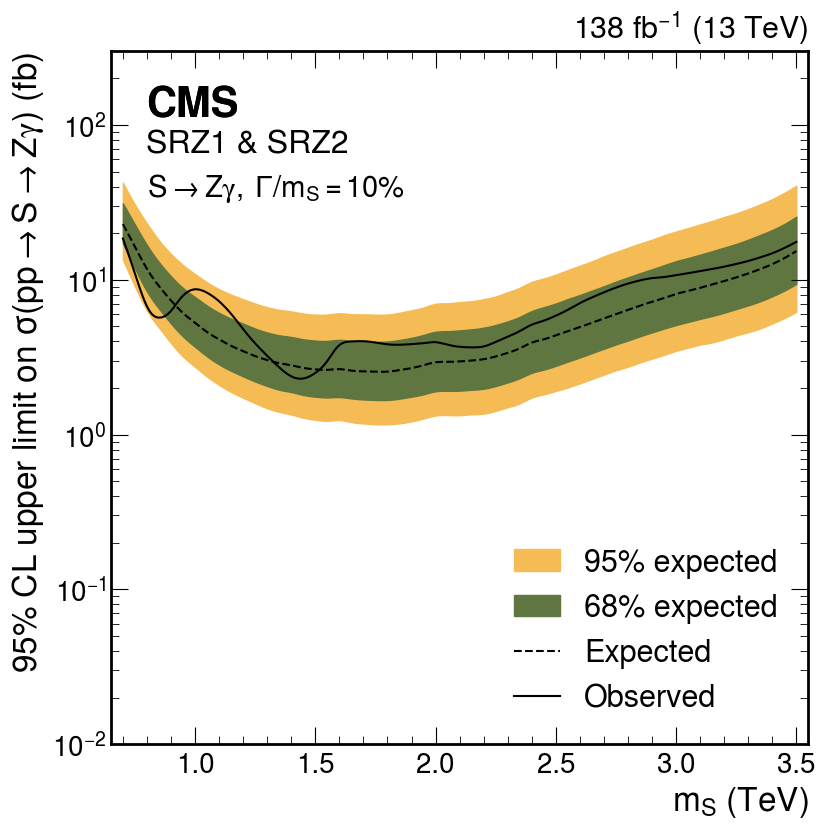

In [8]:
for SR in ['SRZ']:
    limits = pd.read_csv(f'./limit_results/limit_{SR}_VW.csv')
    result = {
        'mass': limits['mass'].values/1000,
        'Expected +2sigma': limits['limit_p2'].values,
        'Expected +1sigma': limits['limit_p1'].values,
        'Expected -1sigma': limits['limit_m1'].values,
        'Expected -2sigma': limits['limit_m2'].values,
        'Expected Limit': limits['limit_exp'].values,
        'Observed Limit': limits['limit_obs'].values,
    }
    plot_cross_section_limit(limits=result, llabel='SRZ1 & SRZ2', text=r'$S\to Z\mathrm{\gamma},\ \Gamma/m_S=10\%$', name=f'{SR}_VW', x_name=r'$m_S$ (TeV)', y_name=r'$\sigma(pp\to S\to Z\mathrm{\gamma})$', year='Run2', y_min=1e-2)

# Significance

## Hgamma

In [ ]:
significance = {'expected': {}, 'observed': {}} 
signal_region = 'SRH'

for f in os.listdir('./Significance/observed'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR !=signal_region or '_' in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/observed/{f}')
    limits = stats['limit']['limit'].array()
    significance['observed'][int(mass)] = float(limits[0])

for f in os.listdir('./Significance/expected'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR !=signal_region or '_' in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/expected/{f}')
    limits = stats['limit']['limit'].array()
    significance['expected'][int(mass)] = float(limits[0])


for i in range(19):
    a=700+50*i
    b=700+50*(i+19)
    c=700+50*(i+38)
    print(f"{a} & {round(significance['expected'][a],3)} & {round(significance['observed'][a],3)} & {b} & {round(significance['expected'][b],3)} & {round(significance['observed'][b],3)} & {c} & {round(significance['expected'][c],3)} & {round(significance['observed'][c],3)} \\\\")

700 & 10.237 & 0.0 & 1650 & 21.611 & 0.743 & 2600 & 11.445 & 0.0 \\
750 & 13.619 & 0.705 & 1700 & 21.078 & 0.07 & 2650 & 10.96 & 0.0 \\
800 & 15.954 & 1.464 & 1750 & 20.522 & 0.0 & 2700 & 10.494 & 0.0 \\
850 & 18.078 & 1.049 & 1800 & 20.002 & 0.0 & 2750 & 10.044 & 0.0 \\
900 & 19.278 & 0.0 & 1850 & 19.46 & 0.0 & 2800 & 9.607 & 0.0 \\
950 & 20.689 & 0.085 & 1900 & 18.952 & 0.0 & 2850 & 9.189 & 0.0 \\
1000 & 21.518 & 0.709 & 1950 & 18.403 & 0.0 & 2900 & 8.78 & 0.0 \\
1050 & 22.521 & 0.0 & 2000 & 17.854 & 0.0 & 2950 & 8.386 & 0.0 \\
1100 & 23.1 & 0.0 & 2050 & 17.252 & 0.0 & 3000 & 8.003 & 0.0 \\
1150 & 23.738 & 0.0 & 2100 & 16.652 & 0.0 & 3050 & 7.633 & 0.0 \\
1200 & 24.09 & 0.0 & 2150 & 16.043 & 0.0 & 3100 & 7.277 & 0.0 \\
1250 & 24.411 & 0.243 & 2200 & 15.471 & 0.0 & 3150 & 6.933 & 0.0 \\
1300 & 24.549 & 0.514 & 2250 & 14.927 & 0.0 & 3200 & 6.599 & 0.0 \\
1350 & 24.511 & 0.0 & 2300 & 14.423 & 0.0 & 3250 & 6.282 & 0.0 \\
1400 & 24.224 & 0.0 & 2350 & 13.928 & 0.0 & 3300 & 5.981 & 0.0 \\
1

## Zgamma narrow

In [ ]:
significance = {'expected': {}, 'observed': {}} 
signal_region = 'SRZ2'

for f in os.listdir('./Significance/observed'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR !=signal_region or '_' in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/observed/{f}')
    limits = stats['limit']['limit'].array()
    significance['observed'][int(mass)] = float(limits[0])

for f in os.listdir('./Significance/expected'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR !=signal_region or '_' in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/expected/{f}')
    limits = stats['limit']['limit'].array()
    significance['expected'][int(mass)] = float(limits[0])


for i in range(19):
    a=700+50*i
    b=700+50*(i+19)
    c=700+50*(i+38)
    print(f"{a} & {round(significance['expected'][a],3)} & {round(significance['observed'][a],3)} & {b} & {round(significance['expected'][b],3)} & {round(significance['observed'][b],3)} & {c} & {round(significance['expected'][c],3)} & {round(significance['observed'][c],3)} \\\\")

700 & 0.134 & 0.196 & 1650 & 2.47 & 0.665 & 2600 & 4.668 & 0.0 \\
750 & 0.264 & 0.454 & 1700 & 2.605 & 1.674 & 2650 & 4.752 & 0.0 \\
800 & 0.286 & 0.0 & 1750 & 2.733 & 2.16 & 2700 & 4.84 & 0.0 \\
850 & 0.38 & 0.0 & 1800 & 2.877 & 2.029 & 2750 & 4.922 & 0.0 \\
900 & 0.417 & 0.0 & 1850 & 3.017 & 1.527 & 2800 & 5.006 & 0.0 \\
950 & 0.556 & 0.0 & 1900 & 3.166 & 0.616 & 2850 & 5.083 & 0.0 \\
1000 & 0.656 & 0.979 & 1950 & 3.299 & 0.0 & 2900 & 5.161 & 0.0 \\
1050 & 0.766 & 1.386 & 2000 & 3.429 & 0.0 & 2950 & 5.231 & 0.0 \\
1100 & 0.884 & 0.988 & 2050 & 3.541 & 0.0 & 3000 & 5.302 & 0.0 \\
1150 & 1.014 & 0.0 & 2100 & 3.651 & 0.0 & 3050 & 5.365 & 0.0 \\
1200 & 1.144 & 0.0 & 2150 & 3.752 & 0.0 & 3100 & 5.427 & 0.0 \\
1250 & 1.303 & 0.727 & 2200 & 3.855 & 0.0 & 3150 & 5.485 & 0.0 \\
1300 & 1.435 & 0.419 & 2250 & 3.964 & 0.0 & 3200 & 5.542 & 0.0 \\
1350 & 1.6 & 0.0 & 2300 & 4.072 & 0.0 & 3250 & 5.596 & 0.0 \\
1400 & 1.749 & 0.0 & 2350 & 4.18 & 0.0 & 3300 & 5.651 & 0.0 \\
1450 & 1.914 & 0.0 & 2400 &

## Zgamma wide

In [ ]:
significance = {'expected': {}, 'observed': {}} 
signal_region = 'SRZ'

for f in os.listdir('./Significance/observed'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR != signal_region or '_5p6' not in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/observed/{f}')
    limits = stats['limit']['limit'].array()
    significance['observed'][int(mass)] = float(limits[0])

for f in os.listdir('./Significance/expected'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR != signal_region or '_5p6' not in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/expected/{f}')
    limits = stats['limit']['limit'].array()
    significance['expected'][int(mass)] = float(limits[0])


for i in range(19):
    a=700+50*i
    b=700+50*(i+19)
    c=700+50*(i+38)
    print(f"{a} & {round(significance['expected'][a],3)} & {round(significance['observed'][a],3)} & {b} & {round(significance['expected'][b],3)} & {round(significance['observed'][b],3)} & {c} & {round(significance['expected'][c],3)} & {round(significance['observed'][c],3)} \\\\")

## Zgamma very wide

In [ ]:
significance = {'expected': {}, 'observed': {}} 
signal_region = 'SRZ'

for f in os.listdir('./Significance/observed'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR != signal_region or '_10p0' not in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/observed/{f}')
    limits = stats['limit']['limit'].array()
    significance['observed'][int(mass)] = float(limits[0])

for f in os.listdir('./Significance/expected'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR != signal_region or '_10p0' not in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/expected/{f}')
    limits = stats['limit']['limit'].array()
    significance['expected'][int(mass)] = float(limits[0])


for i in range(19):
    a=700+50*i
    b=700+50*(i+19)
    c=700+50*(i+38)
    print(f"{a} & {round(significance['expected'][a],3)} & {round(significance['observed'][a],3)} & {b} & {round(significance['expected'][b],3)} & {round(significance['observed'][b],3)} & {c} & {round(significance['expected'][c],3)} & {round(significance['observed'][c],3)} \\\\")

# Deficit

## Hgamma

In [ ]:
signal_region = 'SRH'
deficit = {}
for f in os.listdir('./MultiDimFit/Asimov'):
    if not (f.endswith('.root') and 'MultiDimFit' in f):
        continue

    mass, SR = f.split('.')[1:3]
    mass = int(mass.split('_')[0])

    if SR != signal_region:
        continue
    stats = uproot.open(f'./MultiDimFit/Asimov/{f}')
    r = stats['limit']['r'].array()
    deficit[mass] = r[0]*2/(r[2]-r[1])
    print(r, deficit[mass])



print(min(deficit.values()))

In [ ]:
for m in deficit:
    if deficit[m]< 0:
        print(m, deficit[m])

## Zgamma narrow

In [ ]:
signal_region = 'SRZ'
deficit = {}
for f in os.listdir('./MultiDimFit/Asimov'):
    if not (f.endswith('.root') and 'MultiDimFit' in f):
        continue

    mass, SR = f.split('.')[1:3]
    if SR != signal_region or '_' in mass:
        continue
    mass = int(mass.split('_')[0])
    
    stats = uproot.open(f'./MultiDimFit/Asimov/{f}')
    r = stats['limit']['r'].array()
    deficit[mass] = r[0]*2/(r[2]-r[1])
    #print(r)

print(min(deficit.values()))

In [ ]:
for m in deficit:
    if deficit[m] <= 0:
        print(m, deficit[m])

## Zgamma wide

In [ ]:
signal_region = 'SRZ'
deficit = {}
for f in os.listdir('./MultiDimFit'):
    if not (f.endswith('.root') and 'MultiDimFit' in f):
        continue

    mass, SR = f.split('.')[1:3]
    if SR != signal_region or '_5p6' not in mass:
        continue
    mass = int(mass.split('_')[0])

    stats = uproot.open(f'./MultiDimFit/{f}')
    r = stats['limit']['r'].array()
    deficit[mass] = (r[0]-0)#*2/(r[2] - r[1])
    #print(r)

print(min(deficit.values()))

In [ ]:
for m in deficit:
    if deficit[m]<= min(deficit.values()):
        print(m, deficit[m])

## Zgamma very wide

In [ ]:
signal_region = 'SRZ'
deficit = {}
for f in os.listdir('./MultiDimFit'):
    if not (f.endswith('.root') and 'MultiDimFit' in f):
        continue

    mass, SR = f.split('.')[1:3]
    if SR != signal_region or '_10p0' not in mass:
        continue
    mass = int(mass.split('_')[0])
    
    stats = uproot.open(f'./MultiDimFit/{f}')
    r = stats['limit']['r'].array()
    deficit[mass] = (r[0]-0)#*2/(r[2] - r[1])
    #print(r)

print(min(deficit.values()))

# postfit

In [ ]:
import ROOT


Welcome to JupyROOT 6.30/07


In [ ]:
def postfit(file, mass, SR):
    f = ROOT.TFile(file)
    m = str(mass).split('_')[0]
    w = f.Get("w")
    w.Print("v")

    n_bins = (3700-650)//50
    binning = ROOT.RooFit.Binning(n_bins,650,3700)

    can = ROOT.TCanvas()
    plot = w.var("fit_mass").frame()

    w.data("data_obs").plotOn(plot, binning)

    # Load the S+B model
    sb_model = w.pdf("model_s").getPdf(SR)
    if '_5p6' in str(mass):
        width = ' (wide)'
    elif '_10p0' in str(mass):
        width = ' (very wide)'
    else:
        width = ' (narrow)'
    plot.SetTitle("signal of m="+m+"GeV"+width+" in "+SR)

    # Prefit
    #sb_model.plotOn(plot, ROOT.RooFit.LineColor(2), ROOT.RooFit.Name("prefit"))

    # Postfit
    w.loadSnapshot("MultiDimFit")
    sb_model.plotOn(plot, ROOT.RooFit.LineColor(4), ROOT.RooFit.Name("postfit"))
    r_bestfit = w.var("r").getVal()

    plot.Draw()

    leg = ROOT.TLegend(0.55,0.6,0.85,0.85)
    #leg.AddEntry("prefit", "Prefit S+B model (r=1.00)", "L")
    leg.AddEntry("postfit", "Postfit S+B model (r=%.2f)"%r_bestfit, "L")
    leg.Draw("Same")

    can.Update()
    can.SetLogy()
    os.makedirs('../plots/fit/Run2/', exist_ok=True)
    can.SaveAs(f"../plots/fit/Run2/postfit_{mass}_{SR}.pdf")

In [ ]:
postfit('./higgsCombine.1550.SRH.MultiDimFit.mH120.root', 1550, 'SRH1')
postfit('./higgsCombine.1550.SRH.MultiDimFit.mH120.root', 1550, 'SRH2')

postfit('./higgsCombine.1750.SRZ.MultiDimFit.mH120.root', 1750, 'SRZ1')
postfit('./higgsCombine.1750.SRZ.MultiDimFit.mH120.root', 1750, 'SRZ2')

postfit('./higgsCombine.1750_5p6.SRZ.MultiDimFit.mH120.root', '1750_5p6', 'SRZ1')
postfit('./higgsCombine.1750_5p6.SRZ.MultiDimFit.mH120.root', '1750_5p6', 'SRZ2')

postfit('./higgsCombine.1750_10p0.SRZ.MultiDimFit.mH120.root', '1750_10p0', 'SRZ1')
postfit('./higgsCombine.1750_10p0.SRZ.MultiDimFit.mH120.root', '1750_10p0', 'SRZ2')



RooWorkspace(w) w contents

variables
---------
(Br_Hbb,Br_Hbb_In,CMS_channel,CSEV,CSEV_In,JER,JER_In,JES_2016,JES_2016_In,JES_2017,JES_2017_In,JES_2018,JES_2018_In,L1_prefiring,L1_prefiring_In,MH,PDF,PDF_In,PER,PER_In,PES,PES_In,QCD_scale,QCD_scale_In,Xbb_tagger_SR1,Xbb_tagger_SR1_In,Xbb_tagger_SR2,Xbb_tagger_SR2_In,alphaL,alphaR,fit_mass,jet_mass,lumi_13TeV_1718,lumi_13TeV_1718_In,lumi_13TeV_2016,lumi_13TeV_2016_In,lumi_13TeV_2017,lumi_13TeV_2017_In,lumi_13TeV_2018,lumi_13TeV_2018_In,lumi_13TeV_correlated,lumi_13TeV_correlated_In,nL,nR,n_exp_binSRH1_proc_background,n_exp_binSRH2_proc_background,p1_dijet2,p1_dijet3,p1_expow1,p1_expow2,p1_invpow2,p1_invpow3,p2_dijet2,p2_dijet3,p2_expow2,p2_invpow2,p2_invpow3,p3_dijet3,p3_invpow3,pdfindex_SRH1,pdfindex_SRH2,photon_ID,photon_ID_In,pile-up,pile-up_In,r,shapeBkg_background_SRH1__norm,shapeBkg_background_SRH2__norm,sigmaL,sigmaR,tagger,x0)

p.d.f.s
-------
SimpleGaussianConstraint::Br_Hbb_Pdf[ x=Br_Hbb mean=Br_Hbb_In sigma=1 ] = 1
SimpleGa

Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1550_SRH1.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1550_SRH2.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1750_SRZ1.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1750_SRZ2.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1750_5p6_SRZ1.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1750_5p6_SRZ2.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1750_10p0_SRZ1.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1750_10p0_SRZ2.pdf has been created


# likelihood

 <<< Combine >>> 
 <<< v10.0.2 >>>
>>> Random number generator seed is 123456
>>> Method used is MultiDimFit
Set Range of Parameter r To : (0,2)
Set Default Index of Parameter pdfindex_SRH1 To : -1 (was: 0 )
[#0] ERROR:InputArguments -- RooCategory: Trying to set invalid state -1 for category pdfindex_SRH1
Doing initial fit: 
 POI: r= 1.46372e-13 -> [0,2]
Point 0/50 r = 0.02
Point 1/50 r = 0.06
Point 2/50 r = 0.1
Point 3/50 r = 0.14
Point 4/50 r = 0.18
Point 5/50 r = 0.22
Point 6/50 r = 0.26
Point 7/50 r = 0.3
Point 8/50 r = 0.34
Point 9/50 r = 0.38
Point 10/50 r = 0.42
Point 11/50 r = 0.46
Point 12/50 r = 0.5
Point 13/50 r = 0.54
Point 14/50 r = 0.58
Point 15/50 r = 0.62
Point 16/50 r = 0.66
Point 17/50 r = 0.7
Point 18/50 r = 0.74
Point 19/50 r = 0.78
Point 20/50 r = 0.82
Point 21/50 r = 0.86
Point 22/50 r = 0.9
Point 23/50 r = 0.94
Point 24/50 r = 0.98
Point 25/50 r = 1.02
Point 26/50 r = 1.06
Point 27/50 r = 1.1
Point 28/50 r = 1.14
Point 29/50 r = 1.18
Point 30/50 r = 1.22
Point 3

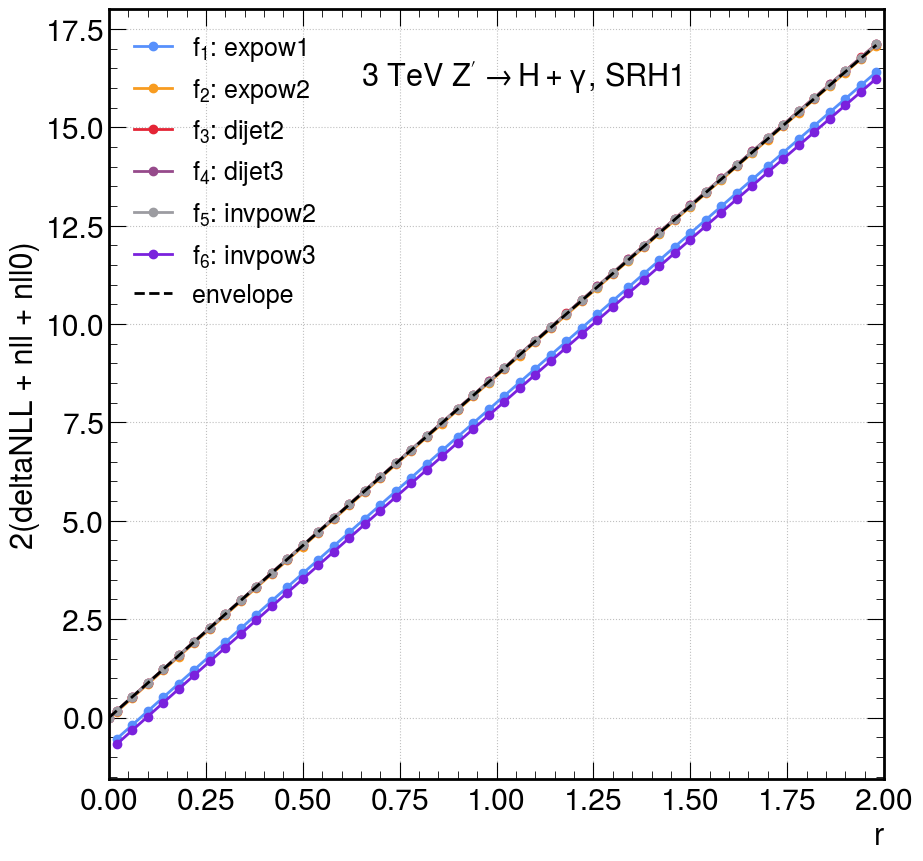

In [ ]:
result = {}
os.system("combine -M MultiDimFit -d datacard/Run2/3000/SRH1.txt --algo grid --setParameterRanges r=0,2 --cminDefaultMinimizerStrategy 0 --saveNLL -n .envelope -m 125 --setParameters pdfindex_SRH1=-1 --X-rtd REMOVE_CONSTANT_ZERO_POINT=1")
result['envelope'] = uproot.open('higgsCombine.envelope.MultiDimFit.mH125.root')
function = {
    0: r'$f_1$: expow1',
    1: r'$f_2$: expow2',
    2: r'$f_3$: dijet2',
    3: r'$f_4$: dijet3',
    4: r'$f_5$: invpow2',
    5: r'$f_6$: invpow3',
}
for i in range(6):
    os.system(f"combine -M MultiDimFit -d datacard/Run2/3000/SRH1.txt --algo grid --setParameterRanges r=0,2 --cminDefaultMinimizerStrategy 0 --saveNLL -n .fixed_pdf_{i} -m 125 --setParameters pdfindex_SRH1={i} --freezeParameters pdfindex_SRH1,pdfindex_SRH2 --X-rtd REMOVE_CONSTANT_ZERO_POINT=1")
    result[function[i]] = uproot.open(f'higgsCombine.fixed_pdf_{i}.MultiDimFit.mH125.root')

x, y = {}, {}
for k in result:
    x[k]=result[k]['limit']['r'].array()
    y[k]=2*(result[k]['limit']['deltaNLL'].array())#+result[k]['limit']['nll'].array()+result[k]['limit']['nll0'].array())

hep.style.use("CMS")
plt.figure(figsize=(10, 10))

for k in result:
    if k == 'envelope':
        continue
    plt.plot(x[k], y[k], '.-', label=k, linewidth=2,markersize=12)
plt.plot(x['envelope'], y['envelope'], '--', label='envelope', color='black', linewidth=2)

plt.xlim(0, 2)
plt.xlabel('r', fontsize=22, ha='right', x=1)
plt.ylabel('2(deltaNLL + nll + nll0)', fontsize=22, ha='center')
plt.text(x=0.65, y=0.9*plt.ylim()[1]+0.1*plt.ylim()[0], s=r'3 TeV $Z^\prime\to H+\gamma$, SRH1', fontsize=22)
plt.grid(True)
plt.legend(loc="best", ncol=1, frameon=False, fontsize=18)

os.makedirs('../plots/fit/Run2/', exist_ok=True)
plt.savefig('../plots/fit/Run2/likelihood_SRH1_3000.pdf', bbox_inches='tight')
plt.show()

 <<< Combine >>> 
 <<< v10.0.2 >>>
>>> Random number generator seed is 123456
>>> Method used is MultiDimFit


Set Range of Parameter r To : (0,2)
Set Default Index of Parameter pdfindex_SRH2 To : -1 (was: 0 )
[#0] ERROR:InputArguments -- RooCategory: Trying to set invalid state -1 for category pdfindex_SRH2
Doing initial fit: 
 POI: r= 1.96241e-17 -> [0,2]
Point 0/50 r = 0.02
Point 1/50 r = 0.06
Point 2/50 r = 0.1
Point 3/50 r = 0.14
Point 4/50 r = 0.18
Point 5/50 r = 0.22
Point 6/50 r = 0.26
Point 7/50 r = 0.3
Point 8/50 r = 0.34
Point 9/50 r = 0.38
Point 10/50 r = 0.42
Point 11/50 r = 0.46
Point 12/50 r = 0.5
Point 13/50 r = 0.54
Point 14/50 r = 0.58
Point 15/50 r = 0.62
Point 16/50 r = 0.66
Point 17/50 r = 0.7
Point 18/50 r = 0.74
Point 19/50 r = 0.78
Point 20/50 r = 0.82
Point 21/50 r = 0.86
Point 22/50 r = 0.9
Point 23/50 r = 0.94
Point 24/50 r = 0.98
Point 25/50 r = 1.02
Point 26/50 r = 1.06
Point 27/50 r = 1.1
Point 28/50 r = 1.14
Point 29/50 r = 1.18
Point 30/50 r = 1.22
Point 31/50 r = 1.26
Point 32/50 r = 1.3
Point 33/50 r = 1.34
Point 34/50 r = 1.38
Point 35/50 r = 1.42
Point 36/50 

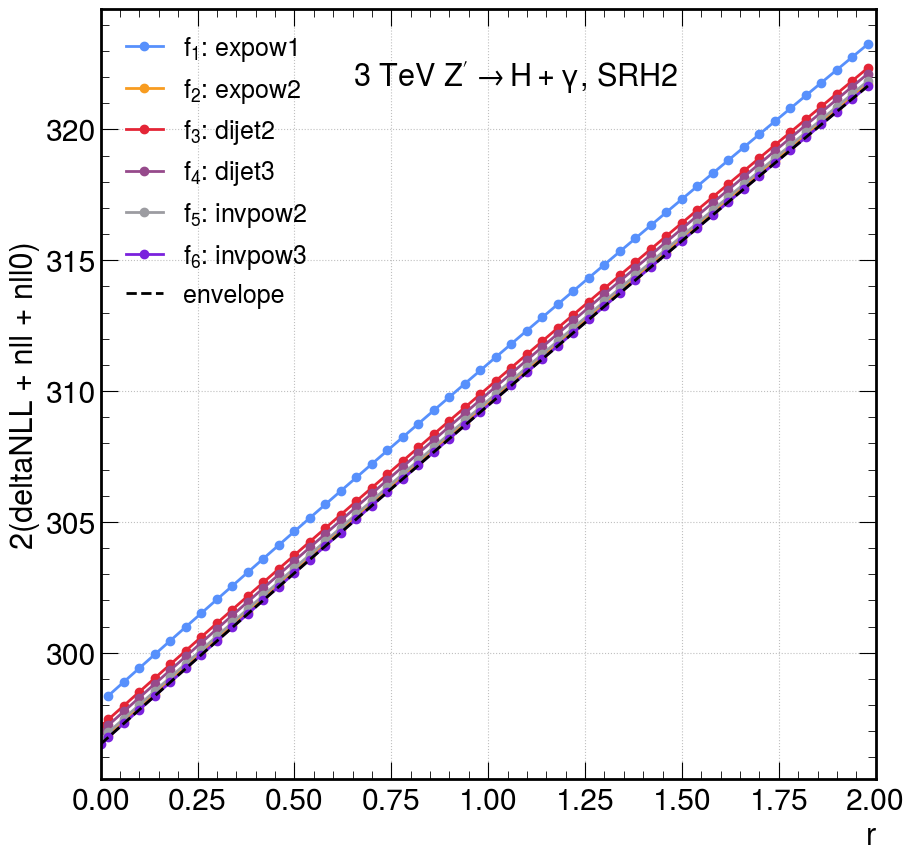

In [ ]:
result = {}
os.system("combine -M MultiDimFit -d datacard/Run2/3000/SRH2.txt --algo grid --setParameterRanges r=0,2 --cminDefaultMinimizerStrategy 0 --saveNLL -n .envelope -m 125 --setParameters pdfindex_SRH1=-1,pdfindex_SRH2=-1 --X-rtd REMOVE_CONSTANT_ZERO_POINT=1")
result['envelope'] = uproot.open('higgsCombine.envelope.MultiDimFit.mH125.root')
function = {
    0: r'$f_1$: expow1',
    1: r'$f_2$: expow2',
    2: r'$f_3$: dijet2',
    3: r'$f_4$: dijet3',
    4: r'$f_5$: invpow2',
    5: r'$f_6$: invpow3',
}
for i in range(6):
    os.system(f"combine -M MultiDimFit -d datacard/Run2/3000/SRH2.txt --algo grid --setParameterRanges r=0,2 --cminDefaultMinimizerStrategy 0 --saveNLL -n .fixed_pdf_{i} -m 125 --setParameters pdfindex_SRH1=-1,pdfindex_SRH2={i} --freezeParameters pdfindex_SRH1,pdfindex_SRH2 --X-rtd REMOVE_CONSTANT_ZERO_POINT=1")
    result[function[i]] = uproot.open(f'higgsCombine.fixed_pdf_{i}.MultiDimFit.mH125.root')

x, y = {}, {}
for k in result:
    x[k]=result[k]['limit']['r'].array()
    y[k]=2*(result[k]['limit']['deltaNLL'].array()+result[k]['limit']['nll'].array()+result[k]['limit']['nll0'].array())

hep.style.use("CMS")
plt.figure(figsize=(10, 10))

for k in result:
    if k == 'envelope':
        continue
    plt.plot(x[k], y[k], '.-', label=k, linewidth=2,markersize=12)
plt.plot(x['envelope'], y['envelope'], '--', label='envelope', color='black', linewidth=2)

plt.xlim(0, 2)
plt.xlabel('r', fontsize=22, ha='right', x=1)
plt.ylabel('2(deltaNLL + nll + nll0)', fontsize=22, ha='center')
plt.text(x=0.65, y=0.9*plt.ylim()[1]+0.1*plt.ylim()[0], s=r'3 TeV $Z^\prime\to H+\gamma$, SRH2', fontsize=22)
plt.grid(True)
plt.legend(loc="best", ncol=1, frameon=False, fontsize=18)

os.makedirs('../plots/fit/Run2/', exist_ok=True)
plt.savefig('../plots/fit/Run2/likelihood_SRH2_3000.pdf', bbox_inches='tight')
plt.show()
